# Title

# Introduction

Heart disease is a term used to describe a number of heart conditions, including a heart attack, an arrhythmia or heart failure. There are many symptoms for heart disease, specifically many symptoms that go unnoticed, and therefore at times it can be difficult to diagnose. What this project aims to do is to predict the presence of heart disease for a patient based on two numerical variables. We chose to use the Heart Disease dataset provided by the course, specifically the Cleveland segment. The variables that we found were the most accurate predictors were ST depression and maximum heart rate. Answering this question with these variables could signify a new way to predict heart disease using data, and possibly saving lives. 

# Preliminary exploratory data analysis

- [Demographics](#Demographics)
- [Summary of numerical variables](#Numerical-Variable)
- [Summary of categorial variables](#Categorial-Variable)

In [1]:
#Load required library
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

set.seed(8205)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

 ## Reading in Heart Disease Data

In [2]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = FALSE) |>
    rename(age      = X1,      # Age in years
           sex      = X2,      # Sex (1 = male, 0 = female)
           cp       = X3,      # Chest pain type 
                               # - 1 : typical angina
                               # - 2 : atypical angina
                               # - 3 : non-anginal pain
                               # - 4 : asymptomatic
           trestbps = X4,      # Resting blood pressure (mmHg)
           chol     = X5,      # Serum cholestoral (mg/dL)
           fbs      = X6,      # Fasting blood sugar > 120 mg/dL (1 = true, 0 = false)
           restecg  = X7,      # Resting electrocardiographic results 
                               # - 0 : normal,
                               # - 1 : having ST-T wave abnormality (T wave inversions and/or ST 
                               #       elevation or depression of > 0.05 mV)
                               # - 2 : showing probable or definite left ventricular hypertrophy by Estes' criteria
           thalach  = X8,      # Maximum heart rate achieved
           exang    = X9,      # Exercise induced angina (0 = no, 1 = yes)
           oldpeak  = X10,     # ST depression induced by exercise relative to rest
           slope    = X11,     # The slope of the peak exercise ST segment
                               # - 1 : upsloping
                               # - 2 : flat
                               # - 3 : downsloping
           ca       = X12,     # Number of major vessels (0-3) colored by flourosopy
           thal     = X13,     # 3 = normal; 6 = fixed defect; 7 = reversable defect
           num      = X14)     # diagnosis of heart disease (angiographic disease status)

cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


## Data wrangling

In [3]:
#Convert columns to sensible data types
cleveland_data <- cleveland_data |>
    mutate(age      = as.integer(age),
           sex      = as.factor(sex),
           cp       = as.factor(cp),
           trestbps = as.integer(trestbps),
           chol     = as.integer(chol),
           fbs      = as.factor(fbs),
           restecg  = as.factor(restecg),
           thalach  = as.integer(thalach),
           exang    = as.factor(exang),
           oldpeak  = as.double(oldpeak),
           slope    = as.factor(slope),
           ca       = as.integer(ca),
           thal     = as.factor(thal),
           num      = as.factor(num)) 

# Creating a new column which is whether or not a person has presence of heart disease
cleveland_data <- cleveland_data |>
    mutate(presence = (num != 0)) |>    
    mutate(presence = as.factor(presence))


cleveland_data

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,presence
<int>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,3,TRUE
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1,TRUE
38,1,3,138,175,0,0,173,0,0.0,1,NA,3.0,0,FALSE


In [4]:
# Splitting the data into training and testing sets
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split) 
cleveland_testing <- testing(cleveland_split)

### Heart Disease Summary

In [5]:
target_summary <- cleveland_training |>
    group_by(presence) |>
    summarize(count = n())
target_summary

presence,count
<fct>,<int>
FALSE,123
TRUE,103


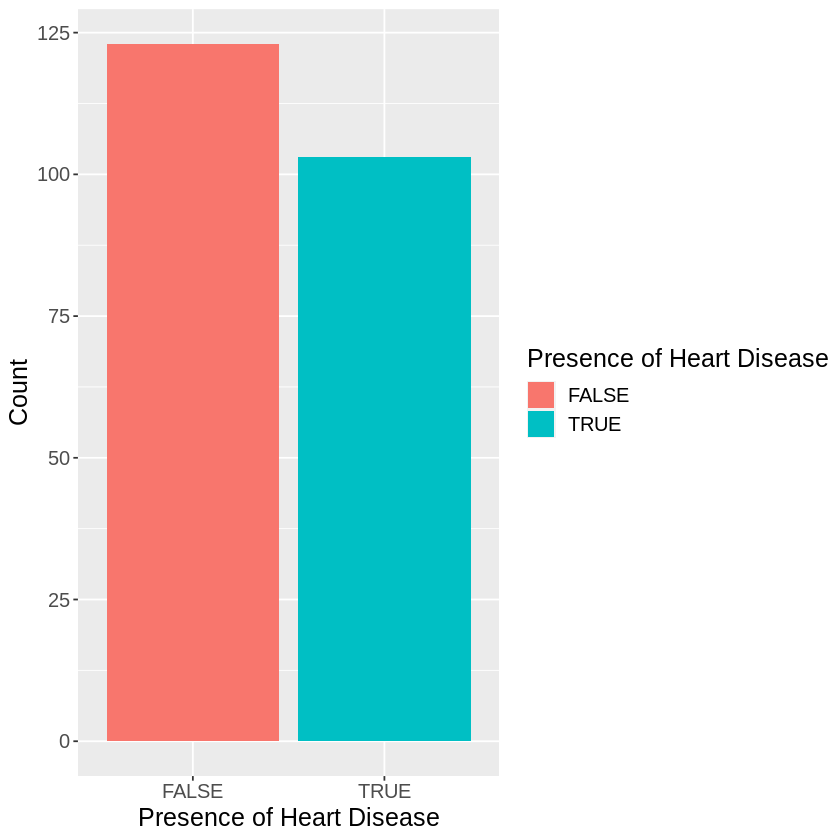

In [6]:
target_summary_plot <- target_summary |>
    ggplot(aes(x = presence, y = count, fill = presence)) +
    geom_bar(stat = "identity") +
    labs(x = "Presence of Heart Disease", y = "Count", fill = "Presence of Heart Disease") +
    theme(text = element_text(size = 15))

target_summary_plot

From the dataset, the majority of patients do not have any presence of heart disease.

### Demographics

In [7]:
demographic_summary <- cleveland_training |>
    group_by(sex) |>
    summarize(count = n(), average_age = mean(age))
demographic_summary

sex,count,average_age
<fct>,<int>,<dbl>
0,73,56.06849
1,153,53.66667


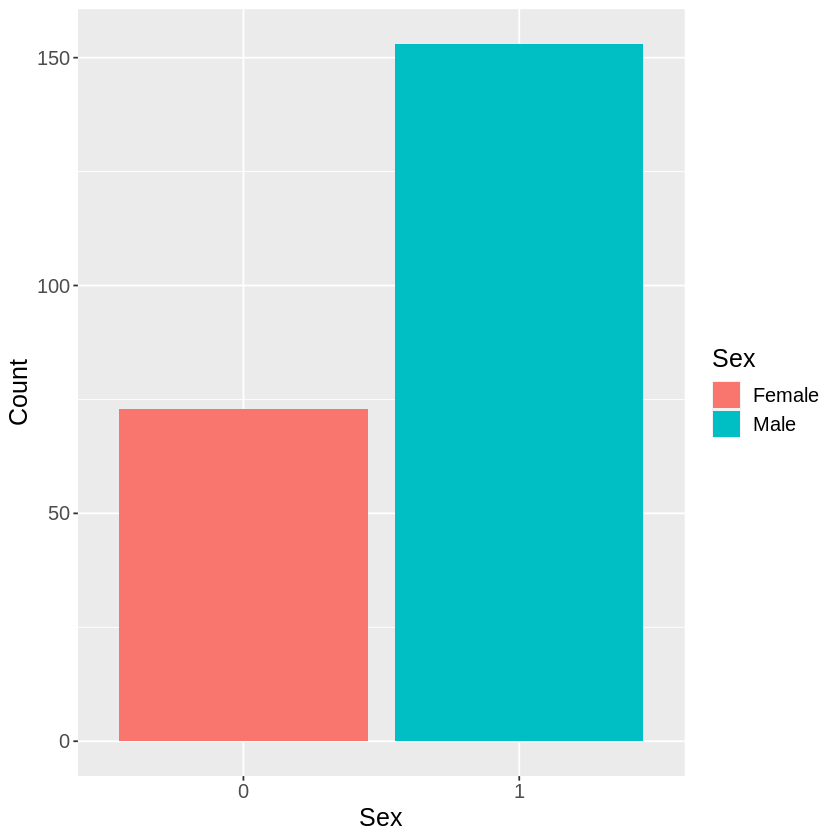

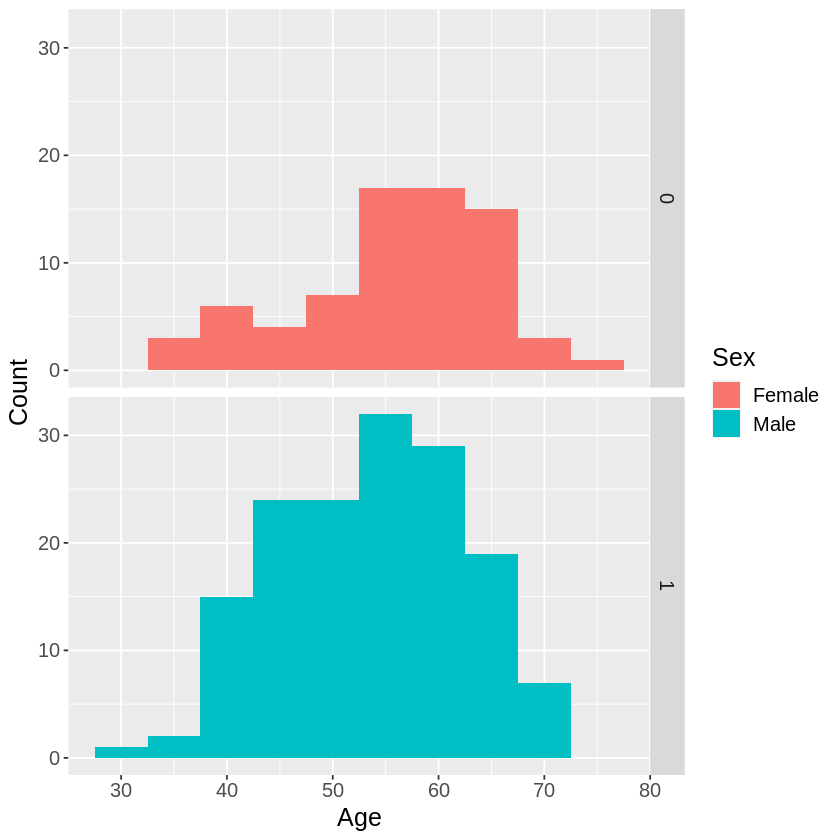

In [8]:
demographic_sex_summary_plot <- demographic_summary |>
    ggplot(aes(x =  sex, y = count, fill = sex)) +
    geom_bar(stat = "identity") +
    labs(x = "Sex", y = "Count", fill = "Sex") +
    scale_fill_discrete(labels = c("Female", "Male")) +
    theme(text = element_text(size = 15))

demographic_age_summary_plot <- cleveland_training |>
    ggplot(aes(x =  age, fill = sex)) +
    geom_histogram(binwidth = 5) +
    labs(x = "Age", y =  "Count", fill = "Sex") +
    scale_fill_discrete(labels = c("Female", "Male")) +
    facet_grid(rows = vars(sex)) +
    theme(text = element_text(size = 15))

demographic_sex_summary_plot
demographic_age_summary_plot

The number of male double that of female participants. The average age for this dataset is around 54 years old. In addition, the average age of the male is slightly younger than female participants.

## Numerical Variable

### Blood Pressure

In [25]:
average_restbps <- cleveland_training |>
    summarize(average_restbps = mean(trestbps))

average_restbps_by_presence <- cleveland_training |>
    group_by(presence) |>
    summarize(average_restbps = mean(trestbps))

average_restbps
average_restbps_by_presence

average_restbps
<dbl>
132.3319


presence,average_restbps
<fct>,<dbl>
FALSE,128.8293
TRUE,136.5146


The average resting blood pressure of all participants is 132*mmHg*. People without heart disease, on average, has lower blood pressure than the sample population and the opposite is true for people with heart disease.

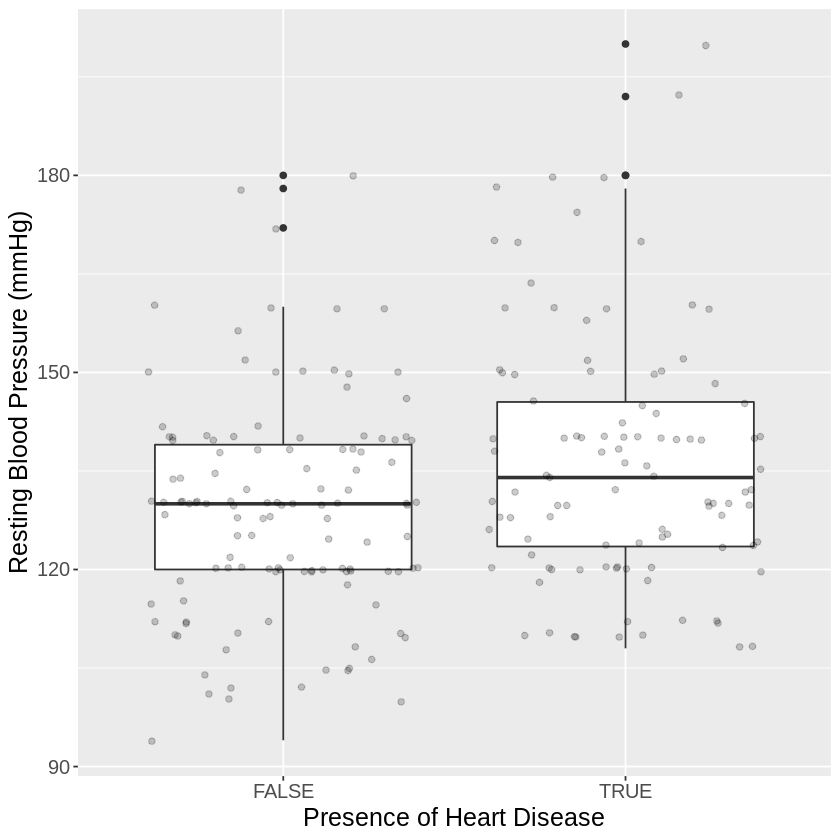

In [11]:
restbps_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, y = trestbps))+
        geom_boxplot()+
        geom_point(position = "jitter", alpha = 0.2) +
        labs(x = "Presence of Heart Disease", y = "Resting Blood Pressure (mmHg)") +
        theme(text = element_text(size = 15))

restbps_summary_plot

People with no presence of heart disease have lower average resting blood pressure. Those who do tend to have slightly higher resting blood pressure. The difference is so small that this probably isn't going to be a good predictor.

### Serum Cholestoral

In [26]:
average_chol <- cleveland_training |>
    summarize(average_chol = mean(chol))

average_chol_by_type <- cleveland_training |>
    group_by(presence) |>
    summarize(average_chol = mean(chol))

average_chol
average_chol_by_type

average_chol
<dbl>
248.5


presence,average_chol
<fct>,<dbl>
FALSE,247.1220
TRUE,250.1456


The average serum cholestoral in the data set is 248.5*mg/dL*. Again, healthy people, on average, have lower serum cholestoral in the blood compared than the sample population and the opposite is true for people with heart disease.

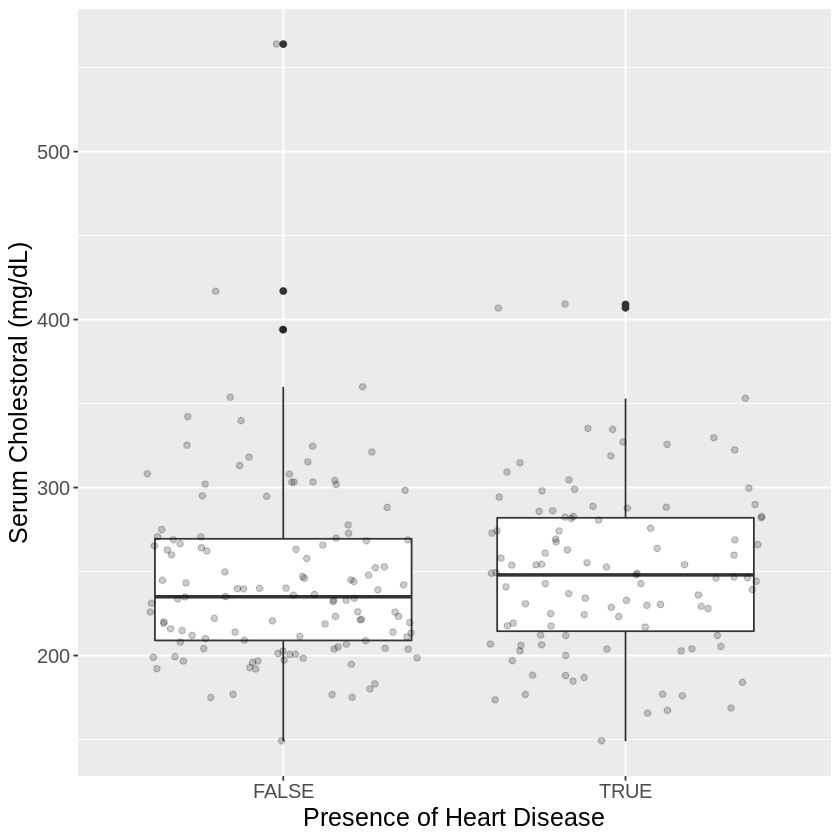

In [14]:
chol_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, y = chol))+
        geom_boxplot()+
        geom_point(position = "jitter", alpha = 0.2) +
        labs(x = "Presence of Heart Disease", y = "Serum Cholestoral (mg/dL)") +
        theme(text = element_text(size = 15))

chol_summary_plot

People who does not have presence of heart disease tend to have slightly less cholestoral in their blood than people with heart disease. Again, the difference is very small so it isn't a very strong correlation and hence we most likely won't choose this as our predictor variable.

### Maximum Heart Rate

In [27]:
average_thalach <- cleveland_training |>
    summarize(average_thalach = mean(thalach))

average_thalach_by_type <- cleveland_training |>
    group_by(presence) |>
    summarize(average_thalach = mean(thalach))

average_thalach_by_type
average_thalach

presence,average_thalach
<fct>,<dbl>
FALSE,158.4309
TRUE,138.8058


average_thalach
<dbl>
149.4867


The average maximum heart rate achieved for this dataset is 149.5 *bpm*. Healthy people, on average, have much lower maximum heart rate compared to the sample population and the opposite is true for people with heart disease.

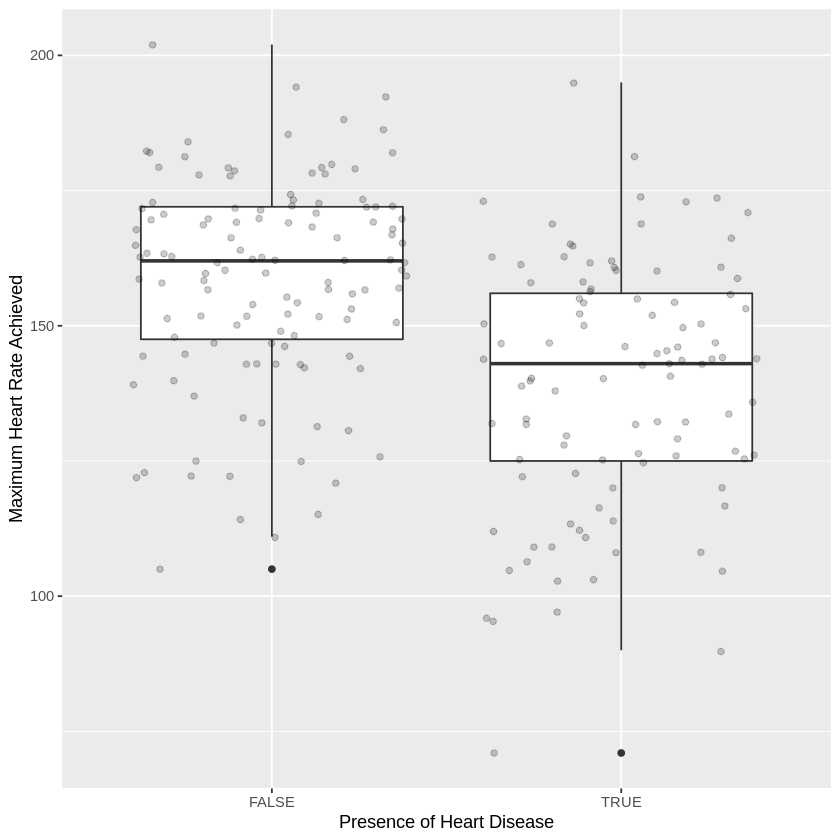

In [17]:
thalach_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, y = thalach)) +
    geom_boxplot() +
    geom_point(position = "jitter", alpha = 0.2) +
    labs(x = "Presence of Heart Disease", y = "Maximum Heart Rate Achieved")

thalach_summary_plot

People who have presence of heart disease tend to have lower maximum heart rate achieved compared to people who don't. However, this time, the difference is a lot more significant, indicating a strong correlation. This is a good candidate predictor variable.

### ST Depression

In [28]:
average_oldpeak <- cleveland_training |>
    summarize(average_oldpeak = mean(oldpeak))

average_oldpeak_by_type <- cleveland_training |>
    group_by(presence) |>
    summarize(average_oldpeak = mean(oldpeak))

average_oldpeak_by_type
average_oldpeak

presence,average_oldpeak
<fct>,<dbl>
FALSE,0.5910569
TRUE,1.5611650


average_oldpeak
<dbl>
1.033186


From the dataset, the average ST depression is about 1*mm*. Healthy people have much lower ST depression compared to the sample population and the opposite is true for people with heart disease.

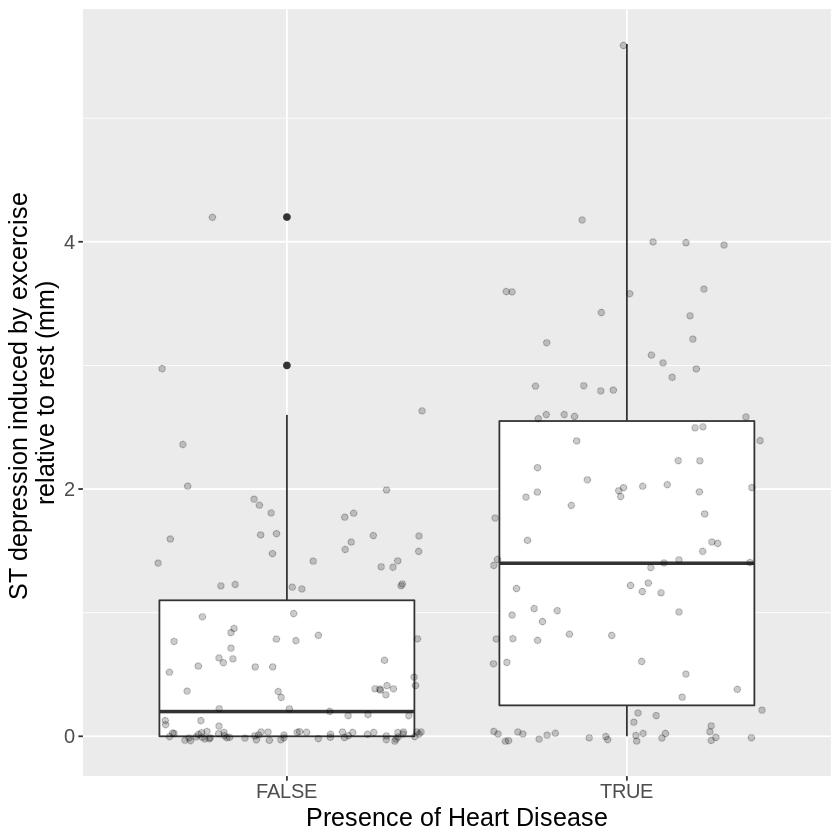

In [20]:
oldpeak_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, y = oldpeak)) +
    geom_boxplot() +
    geom_point(position = "jitter", alpha = 0.2) +
    labs(x = "Presence of Heart Disease",y = "ST depression induced by excercise \nrelative to rest (mm)") +
    theme(text = element_text(size = 15))

oldpeak_summary_plot

Electrocardiography is the process of producing an electrocardiogram. It is a graph of voltage versus time of the electrical activity of the heart using electrodes placed on the skin. ST depression refers to a finding on an electrocardiogram, wherein the trace in the ST segment is abnormally low below the baseline. We can see that healthy people tend to don't or have ST depression less than 1*mm* compared to sick people. This is a very good candidate as a predictor variable.

## Categorial Variable 

### Fasting Blood Sugar

In [21]:
disease_count <- c(123, 103)

fbs_summary <- cleveland_training |>
    group_by(presence, fbs) |>
    summarize(count = n()) 

fbs_lower_than_proportion <- fbs_summary |>
    filter(fbs == 0) |> 
    bind_cols(type_count = disease_count) |>
    mutate(lower_than_proportion = count / type_count) |>
    select(presence, lower_than_proportion)

fbs_summary
fbs_lower_than_proportion

`summarise()` has grouped output by 'presence'. You can override using the
`.groups` argument.


presence,fbs,count
<fct>,<fct>,<int>
FALSE,0,107
FALSE,1,16
TRUE,0,88
TRUE,1,15


presence,lower_than_proportion
<fct>,<dbl>
FALSE,0.8699187
TRUE,0.8543689


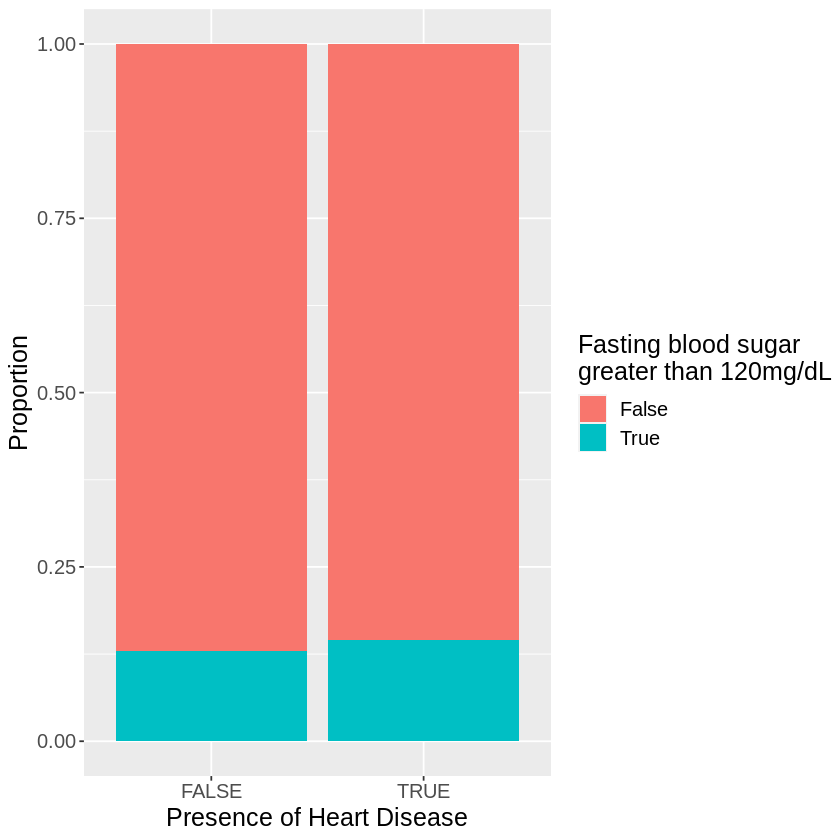

In [22]:
fbs_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, fill = fbs)) +
    geom_bar(position = "fill") +
    labs(x = "Presence of Heart Disease", y = "Proportion", fill = "Fasting blood sugar \ngreater than 120mg/dL") +
    scale_fill_discrete(labels = c("False", "True")) +
    theme(text = element_text(size = 15))
fbs_summary_plot

There is essentially no difference in the proportion of people with fasting blood sugar greater than 120*mg/dL* between people with and without heart disease. Therefore this wouldn't a good predictor variable.

### Exercise Induced Angina

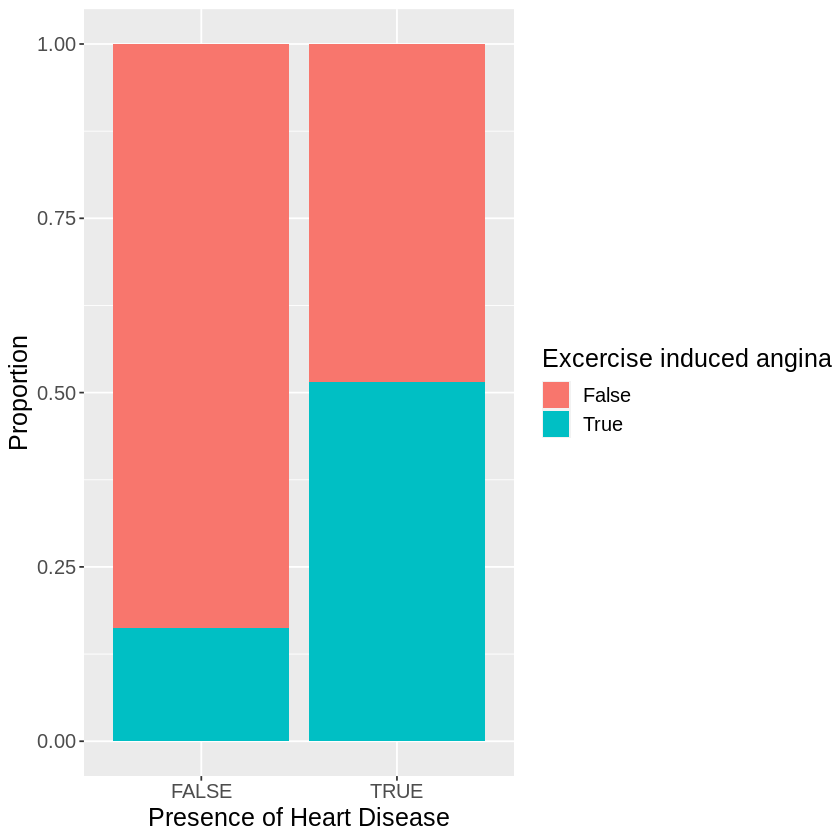

In [23]:
exang_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, fill = exang)) +
    geom_bar(position = "fill") +
    labs(x = "Presence of Heart Disease", y = "Proportion", fill = "Excercise induced angina") +
    scale_fill_discrete(labels = c("False", "True")) +
    theme(text = element_text(size = 15))
exang_summary_plot

Exercise induced angina is a feeling like pressure in the chest, jaw or arm. It frequently may occur with exercise or stress. We can see that many healthy people don't have exercise induced angina, while many sick people do have it. So this might be a good sign of heart disease. However we can't use this variable using $K$-nearest neighbor classification method.

### Slope of the Peak Exercise ST Segment

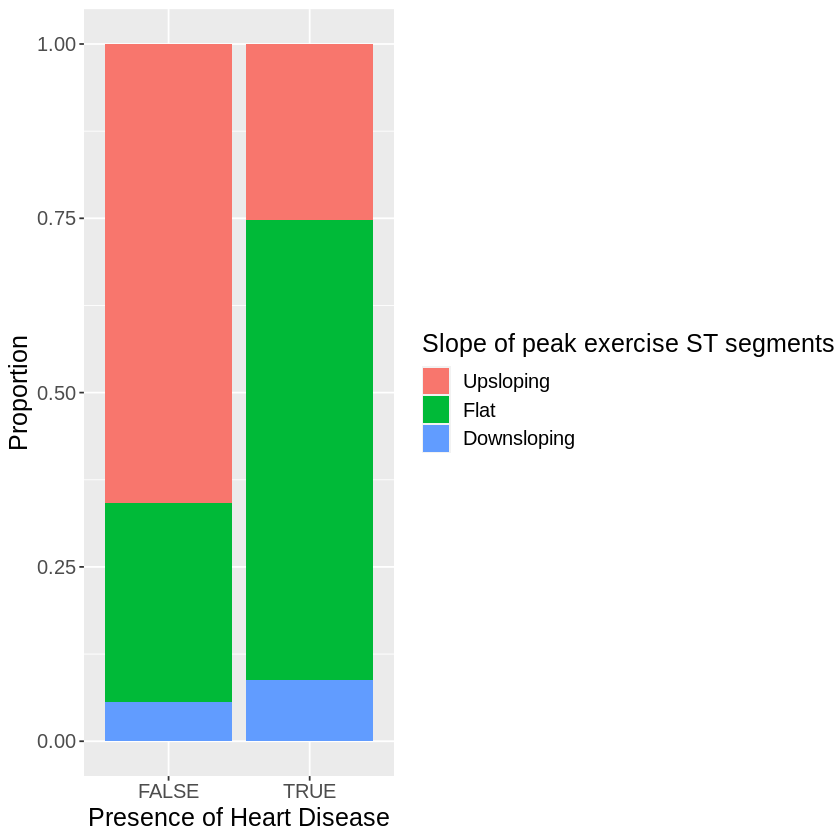

In [24]:
slope_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, fill = slope)) +
    geom_bar(position = "fill") +
    labs(x = "Presence of Heart Disease",y = "Proportion", fill = "Slope of peak exercise ST segments") +
    scale_fill_discrete(labels = c("Upsloping", "Flat", "Downsloping")) +
    theme(text = element_text(size = 15))
slope_summary_plot

From this plot, we can see that most healthy people have upsloping ST segments whereas sick people tend to have flat segments. This again could have made a good predictor variable.

## Methods

**Goal**: Predict the presence class (presence of heart disease) by using a $K$-nearest neighbor classification model and the most reliable predicting variables.
1. Tidy the data.
2. Split the data into training and testing datasets.
3. Group by presence of heart disease and summarise data to find the mean of each variable. 
4. Visualise with bar plots and boxplots to visualise how each mean is distributed and identify correlations. 
5. We will use the [maximum heart rate](#Maximum-Heart-Rate) and [oldpeak](#ST-Depression) as predicting variables because they show correlation to the diagnosis of heart disease. 
6. Choose the $K$ value that yields the highest accuracy and construct the final predicting model.
7. Evaluate this model to come to our conclusion.
8. Visualise our results by plotting our two predictor variables using a scatter plot and highlighting which areas represent diagnosis of heart disease and with a scatterplot of testing data on top to visually asess how our model performed.


## Expected Outcomes and Significance

Our goal is to predict whether a patient has heart disease based on their basic medical information such as ST depression, blood pressure, serum cholesterol, maximum heart rate, *etc,.* We are expecting that if a patient’s testing result of a predictor variable, in our case, [maximum heart rate](#Maximum-Heart-Rate) and ST depression ([oldpeak](#ST-Depression)), falls into a specific range then the person is more likely to have heart disease. 

Such findings would lead to positive impacts on society because being able to predict the presence of heart disease with these variables could allow for early diagnosis. This could allow us to treat the disease as early as possible, before the disease becomes too harmful.  

Our findings could lead to some future questions, such as is there a specific range of maximum heart rate and ST depression that can predict the level of heart disease. Or are there other variables that are more accurate at predicting heart disease that are not present in this data set? Such a question requires further analysis of the data, and we would likely need a dataset consisting of more patient observations.
